In [2]:
import deeplake
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import models,layers
ds = deeplake.load('hub://activeloop/plantvillage-without-augmentation')

C:\Users\satya\anaconda3\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.0.10) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


hub://activeloop/plantvillage-without-augmentation loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/plantvillage-without-augmentation


## Visualization using deeplake library 


deep lake is an amazing library to visualize image datasets dynamically . It has many inbuilt datasets . Below , The plantVillage Dataset has been visualized dynamically using this library . 

In [3]:
ds.visualize()

 * Serving Flask app "dataset_visualizer" (lazy loading)
 * Environment: production


   Use a production WSGI server instead.
 * Debug mode: off


In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\satya\OneDrive\Desktop\PlantVillage",
                                                    shuffle=True,image_size=(256,256),
                                                   batch_size=32)

## Anomaly detection in unhealthy leaves

Alibi Detect is an open source Python library focused on outlier, adversarial and drift detection. The package aims to cover both online and offline detectors for tabular data, text, images and time series. The outlier detection methods should allow the user to identify global, contextual, and collective outliers.

The main purpose is not classifying but to see the anomalies in the diseased leaves to better understand what makes it different from a healthy leaf

In [4]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

2.9.1


In [14]:
import alibi_detect
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

In [6]:
image_directory = 'C:/Users/satya/OneDrive/Desktop/PlantVillage/'
SIZE = 64
dataset = [] 
good_images = os.listdir(image_directory+'Potato___healthy/')
for i, image_name in enumerate(good_images):
        image = cv2.imread(image_directory + 'Potato___healthy/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
dataset = np.array(dataset)
dataset

array([[[[129, 122, 143],
         [135, 128, 149],
         [133, 126, 147],
         ...,
         [133, 127, 146],
         [134, 128, 147],
         [135, 129, 148]],

        [[137, 130, 151],
         [136, 129, 150],
         [132, 125, 146],
         ...,
         [135, 129, 148],
         [139, 133, 152],
         [137, 131, 150]],

        [[141, 134, 155],
         [139, 132, 153],
         [134, 127, 148],
         ...,
         [140, 134, 153],
         [139, 133, 152],
         [140, 134, 153]],

        ...,

        [[172, 165, 180],
         [176, 169, 184],
         [171, 164, 179],
         ...,
         [163, 153, 166],
         [159, 149, 162],
         [155, 145, 158]],

        [[170, 163, 178],
         [176, 169, 184],
         [175, 168, 183],
         ...,
         [162, 152, 165],
         [157, 147, 160],
         [160, 150, 163]],

        [[173, 166, 181],
         [174, 167, 182],
         [176, 169, 184],
         ...,
         [160, 150, 163],
        

In [7]:
len(dataset)

152

In [8]:
train = dataset[0:100]
test = dataset[100:]

train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [9]:
bad_images = os.listdir(image_directory + 'Potato___Early_blight/')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
        image = cv2.imread(image_directory + 'Potato___Early_blight/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.
bad_dataset

array([[[[0.59607846, 0.5686275 , 0.5803922 ],
         [0.5764706 , 0.54901963, 0.56078434],
         [0.5803922 , 0.5529412 , 0.5647059 ],
         ...,
         [0.7019608 , 0.6745098 , 0.6862745 ],
         [0.7019608 , 0.6745098 , 0.6862745 ],
         [0.70980394, 0.68235296, 0.69411767]],

        [[0.5921569 , 0.5647059 , 0.5764706 ],
         [0.5803922 , 0.5529412 , 0.5647059 ],
         [0.57254905, 0.54509807, 0.5568628 ],
         ...,
         [0.7058824 , 0.6784314 , 0.6901961 ],
         [0.7019608 , 0.6745098 , 0.6862745 ],
         [0.7254902 , 0.69803923, 0.70980394]],

        [[0.5568628 , 0.5294118 , 0.5411765 ],
         [0.5882353 , 0.56078434, 0.57254905],
         [0.5647059 , 0.5372549 , 0.54901963],
         ...,
         [0.7176471 , 0.6901961 , 0.7019608 ],
         [0.7137255 , 0.6862745 , 0.69803923],
         [0.69803923, 0.67058825, 0.68235296]],

        ...,

        [[0.54901963, 0.49411765, 0.50980395],
         [0.5137255 , 0.45882353, 0.4745098 ]

In [10]:
encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 

#Define encoder
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

print(encoder_net.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
#Define the decoder. 
#Start with the bottleneck dimension (encoder vector) and connect to dense layer 
#with dim = total nodes in the last conv. in the encoder. 
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

print(decoder_net.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32768)             33587200  
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 256)      2097408   
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 64)       262208    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 64, 64, 3)        3075      
 ranspose)                                                       
                                                      

In [17]:
latent_dim = 1024  #(Same as encoding dim. )

# initialize outlier detector
od = OutlierAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                )

print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.015


In [50]:
adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train,
       optimizer = adam,
       epochs=100,
       batch_size=4,
       verbose=True)

25/25 [=] - 11s 440ms/step - loss_ma: 1.6386e-04


In [34]:
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.021522853970527653


In [35]:
od.infer_threshold(test, outlier_type='instance', threshold_perc=99.0)
print("Current threshold value is: ", od.threshold)


Current threshold value is:  0.021639552973210813


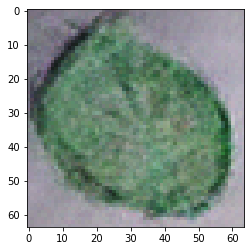

In [36]:
img_num = 15
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.ae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image)

The instance score is: 0.014551767
Is this image an outlier (0 for NO and 1 for YES)? 0


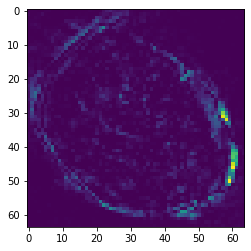

In [37]:
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])


# VISUALZING THE ANOMALIES 

### Visulaizing the Healthy leaves 

['instance_score', 'feature_score', 'is_outlier']


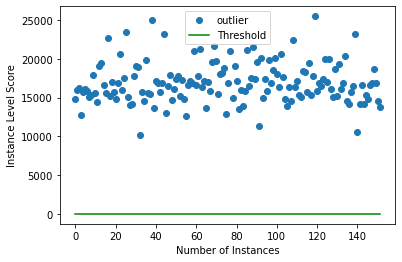

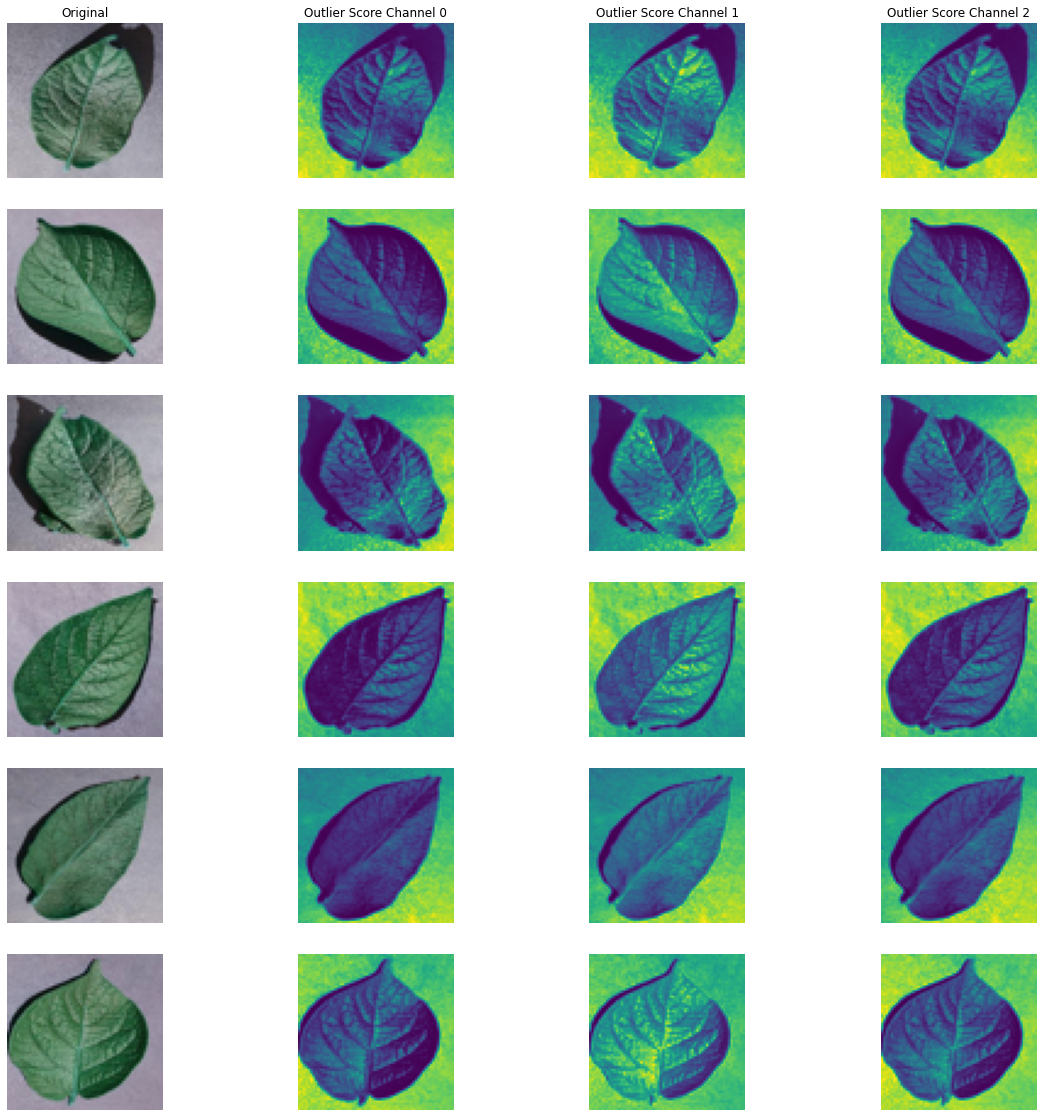

In [107]:
X = dataset

od_preds = od.predict(X,
                      outlier_type='instance',    
                      return_feature_score=True,  
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) 

#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.ae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           instance_ids=[4, 5, 10, 15, 17,20],  
                           max_instances=6,  
                           outliers_only=True) 

As seen above , If we try to detect anomalies in a good leaf , we find none as depicted by the thermal imagery of the leaves . Take a look at the graph above , we can see that all the instance scores of data points lie above the threshold value which means they cannot be classified as an anomaly . 

### Visualizing the diseased leaves

['instance_score', 'feature_score', 'is_outlier']


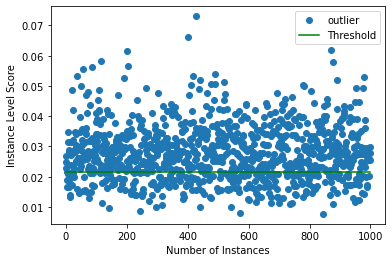

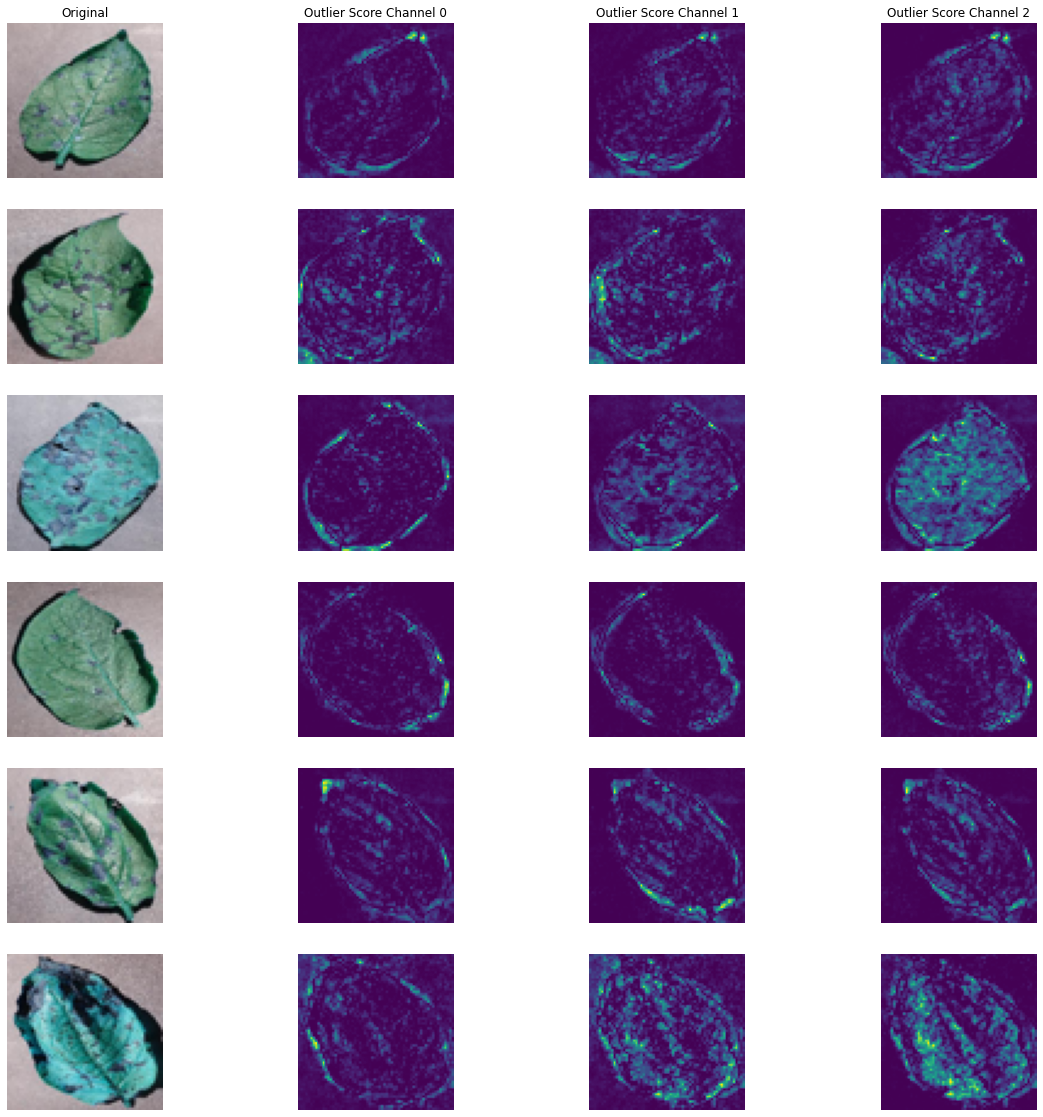

In [108]:
X = bad_dataset

od_preds = od.predict(X,
                      outlier_type='instance',    
                      return_feature_score=True,  
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) 

#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.ae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           instance_ids=[4, 5, 10, 15, 17,20],  
                           max_instances=6,  
                           outliers_only=True) 

Here we can see that the thermal imagery of the diseased leaves do not appear to be clear at all , instead small blobs of green can be seen on them , these green blobs indicate the presence of an anomaly in that area . If we look at the graph above we can see that there are fair amount of instance scores of data points that lie below the threshold value . 

# Localization Of the Anomalies

In this section we will try to locate the anomalies by drawing a square around them ..

In [56]:
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16 #I am using vgg16 to make it short , any other model can be used as well . 
from tensorflow.keras.optimizers import Adam, SGD
import scipy 


import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [59]:

SIZE = 224
total_dataset = []  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

image_directory = 'C:/Users/satya/OneDrive/Desktop/PlantVillage/'
good_images_potato = os.listdir(image_directory+'Potato___healthy/')
for i, image_name in enumerate(good_images):
        image = cv2.imread(image_directory + 'Potato___healthy/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        total_dataset.append(np.array(image))
        label.append(1)


bad_images_potato = os.listdir(image_directory + 'Potato___Early_blight/')
for i, image_name in enumerate(bad_images):
        image = cv2.imread(image_directory + 'Potato___Early_blight/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        total_dataset.append(np.array(image))
        label.append(0)
total_dataset = np.array(total_dataset)
label = np.array(label)
total_dataset

array([[[[138, 131, 152],
         [122, 115, 136],
         [129, 122, 143],
         ...,
         [135, 129, 148],
         [134, 128, 147],
         [129, 123, 142]],

        [[107, 100, 121],
         [147, 140, 161],
         [143, 136, 157],
         ...,
         [138, 132, 151],
         [138, 132, 151],
         [135, 129, 148]],

        [[132, 125, 146],
         [135, 128, 149],
         [118, 111, 132],
         ...,
         [138, 132, 151],
         [137, 131, 150],
         [136, 130, 149]],

        ...,

        [[157, 150, 165],
         [180, 173, 188],
         [169, 162, 177],
         ...,
         [151, 141, 154],
         [161, 151, 164],
         [179, 169, 182]],

        [[172, 165, 180],
         [171, 164, 179],
         [169, 162, 177],
         ...,
         [167, 157, 170],
         [158, 148, 161],
         [148, 138, 151]],

        [[187, 180, 195],
         [176, 169, 184],
         [187, 180, 195],
         ...,
         [174, 164, 177],
        

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(total_dataset, label, test_size = 0.20, random_state = 0)



X_train = X_train /255.
X_test = X_test /255.
#Since we will be using categorical cross entropy loss, we need to convert our Y values to categorical. 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [61]:
def get_model(input_shape = (224,224,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False 
    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(2, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model

In [62]:
model = get_model(input_shape = (224,224,3))
print(model.summary())

history = model.fit(X_train, y_train, batch_size=16, epochs=30, verbose = 1, 
                    validation_data=(X_test,y_test))


input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Co

### plotting loss and accuracy vs epochs

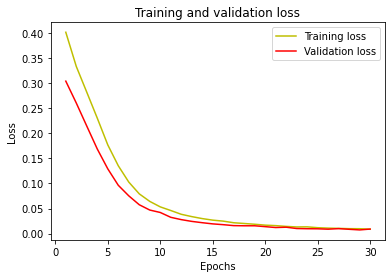

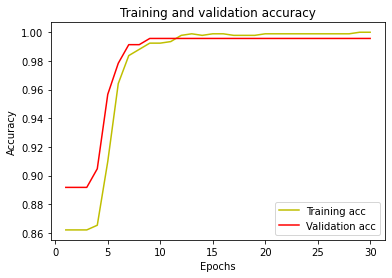

In [63]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### analyzing our detection model using confusion matrix 

8/8 [==============================] - 25s 3s/step - loss: 0.0090 - accuracy: 0.9957
Accuracy =  99.56709742546082 %
1/1 [==============================] - 1s 594ms/step
The prediction for this image is:  1
The actual label for this image is:  1
8/8 [==============================] - 25s 3s/step


<AxesSubplot:>

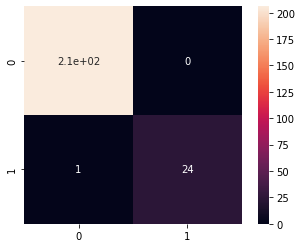

In [64]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

#Test on single image.
n=10  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))

#Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
sns.heatmap(cm, annot=True)

In [74]:
bad_image_idx = np.where(y_pred == 0)[0]
unhealthy=[]
for i in bad_image_idx:
    par_img = X_test[i]
    unhealthy.append(par_img)
    
unhealthy = np.array(unhealthy)    
unhealthy

array([[[[0.74509804, 0.69411765, 0.70196078],
         [0.74117647, 0.69019608, 0.69803922],
         [0.73333333, 0.68235294, 0.69019608],
         ...,
         [0.80784314, 0.75686275, 0.76470588],
         [0.81568627, 0.76470588, 0.77254902],
         [0.80784314, 0.75686275, 0.76470588]],

        [[0.74901961, 0.69803922, 0.70588235],
         [0.74509804, 0.69411765, 0.70196078],
         [0.7372549 , 0.68627451, 0.69411765],
         ...,
         [0.8       , 0.74901961, 0.75686275],
         [0.79215686, 0.74117647, 0.74901961],
         [0.77647059, 0.7254902 , 0.73333333]],

        [[0.75294118, 0.70196078, 0.70980392],
         [0.74901961, 0.69803922, 0.70588235],
         [0.7372549 , 0.68627451, 0.69411765],
         ...,
         [0.8       , 0.74901961, 0.75686275],
         [0.78823529, 0.7372549 , 0.74509804],
         [0.77254902, 0.72156863, 0.72941176]],

        ...,

        [[0.53333333, 0.49019608, 0.50196078],
         [0.55686275, 0.51372549, 0.5254902 ]

The following code block contains a function that takes the image as an argument and returns the coordinates of the anomalies detected in the image , we are going to use this function later to visualize our anomalies later 

In [109]:
from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 
def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("block5_conv3").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    #Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #with rel threshold of 0.3 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.3, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none')) # can be done using opencv as well
    return peak_coords
    

### visualizing the anomalies 

1/1 [==============================] - 0s 224ms/step
0
1
2
3
1/1 [==============================] - 0s 216ms/step
0
1
2
3
1/1 [==============================] - 0s 205ms/step
0
1
2
3
1/1 [==============================] - 1s 562ms/step
0
1
2
3
1/1 [==============================] - 0s 200ms/step
0
1
2
3
4
1/1 [==============================] - 0s 205ms/step
0
1
2
3
4
1/1 [==============================] - 0s 211ms/step
0
1
2
1/1 [==============================] - 0s 206ms/step
0
1
2
1/1 [==============================] - 0s 209ms/step
0
1
2
3
4
1/1 [==============================] - 0s 210ms/step
0
1
2
3
4
1/1 [==============================] - 0s 215ms/step
0
1
1/1 [==============================] - 0s 201ms/step
0
1
1/1 [==============================] - 0s 220ms/step
0
1
2
3
1/1 [==============================] - 0s 207ms/step
0
1
2
3
1/1 [==============================] - 0s 206ms/step
0
1/1 [==============================] - 0s 206ms/step
0
1/1 [==============================] - 0

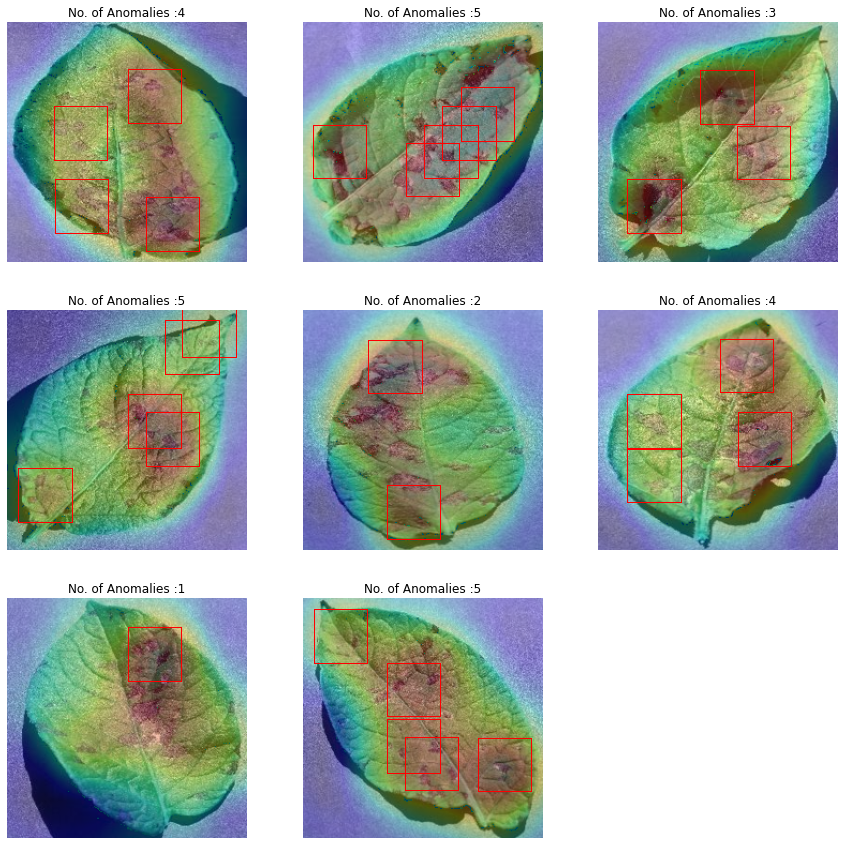

In [116]:
diseased=unhealthy[:9]
plt.figure(figsize=(15,15))
for i in range(9):
    im = diseased[i]
    plot_heatmap(im)
    img = im
    plt.title(f"No. of Anomalies :{len(plot_heatmap(im))}")
    ax= plt.subplot(3,3,i+1)
    #plt.imshow(heat_map)
    plt.axis('off')